In [314]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score)
import csv
import numpy as np

In [315]:
model_data = pd.read_parquet('../data/processed/api_processed/sample_10.parquet')
# For slimmer file output (I'm doing this in post-production)
model_data['Start time'] = model_data['Start time'].astype(str)
model_data = model_data.dropna()

for col in ['Bike model', 'season', 'Type of day']:
    value_counts = model_data[col].value_counts(normalize=True, dropna=False)
    print(f"\nColumn: {col}")
    print(value_counts.round(3))


Column: Bike model
Bike model
CLASSIC       0.851
PBSC_EBIKE    0.149
Name: proportion, dtype: float64

Column: season
season
summer    0.587
winter    0.413
Name: proportion, dtype: float64

Column: Type of day
Type of day
workday    0.808
weekend    0.192
Name: proportion, dtype: float64


In [316]:
model_data = model_data.rename(columns={'Total duration (m)': 'real_duration', 'Type of day': 'type_of_day', 'Bike model': 'bike_model'})

In [317]:
# Get rid of weird values
model_data = model_data[model_data['real_duration'] > 0]

In [318]:
model_data['cycling_delta_pct'] = (model_data['real_duration'] - model_data['cycling']) / model_data['real_duration']
def is_cyclist_efficient(cycling_efficiency):
    if cycling_efficiency < 0.15:
        return 1
    else:
        return 0
    
model_data['cyclist_class'] = model_data['cycling_delta_pct'].apply(is_cyclist_efficient)
model_data['cyclist_class'].value_counts()

cyclist_class
1    48816
0    33416
Name: count, dtype: int64

In [319]:
def class_time_of_day(times):
    times_reformatted = int(times[:2])
    if 6 < times_reformatted < 10:
        return 'morning'
    elif times_reformatted < 16:
        return 'midday'
    elif times_reformatted < 20:
        return 'evening'
    else:
        return 'night'

model_data['time_class'] = model_data['Start time'].apply(class_time_of_day)
model_data['time_class'].value_counts()

time_class
evening    27693
midday     27108
morning    17854
night       9577
Name: count, dtype: int64

In [320]:
def distance_journey(duration):
    if duration < 5:
        return 'short_distance'
    elif duration < 15:
        return 'medium_distance'
    else:
        return 'long_distance'

model_data['distance_class'] = model_data['real_duration'].apply(distance_journey)
model_data['distance_class'].value_counts()

distance_class
medium_distance    38282
long_distance      34865
short_distance      9085
Name: count, dtype: int64

In [321]:
model_data['cycling_public_delta_pct'] = (model_data['cycling'] - model_data['public_transport']) / model_data['cycling']
model_data['cycling_public_delta_pct'] = model_data['cycling_public_delta_pct'].replace([np.inf, -np.inf], np.nan)
model_data['cycling_public_delta_pct'].describe()

count    82102.000000
mean        -1.437411
std          1.003495
min        -17.000000
25%         -2.000000
50%         -1.230769
75%         -0.722222
max          1.000000
Name: cycling_public_delta_pct, dtype: float64

In [322]:
train_data, test_data = train_test_split(
    model_data,
    test_size=0.2,
    random_state=42
)
model_data = train_data
model_data.shape

(65785, 18)

In [323]:
formula_string = "cyclist_class ~ C(type_of_day, Treatment(reference='workday')) + C(time_class, Treatment(reference='morning')) + C(season, Treatment(reference='summer')) + cycling_public_delta_pct + C(distance_class, Treatment(reference='medium_distance')) + C(bike_model)"
model = sm.formula.logit(formula=formula_string, data=model_data)
model_fitted = model.fit()

model_fitted.summary()

Optimization terminated successfully.
         Current function value: 0.519940
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          cyclist_class   No. Observations:                65680
Model:                          Logit   Df Residuals:                    65670
Method:                           MLE   Df Model:                            9
Date:                Fri, 30 May 2025   Pseudo R-squ.:                  0.2295
Time:                        15:52:24   Log-Likelihood:                -34150.
converged:                       True   LL-Null:                       -44320.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       3.4220      0.037     93.335      0.000       3.350       3.494
C(type_of_day, Treatment(reference='workday'))[T.weekend]                      -0.5619      0.024    -23.295      0.000      -0.609      -0.515
C(time_class, Treatment(reference='morning'))[T.evening]                       -0.5237      0.027    -19.720      0.000      -0.576      -0.472
C(time_class, Treatment(reference='morning'))[T.midday]                        -0.6688      0.027    -24.585      0.000      -0.722      -0.616
C(time_class, Treatment(reference='morning'))[T.night]                         -0.8037      0.035    -23.199      0.000      -0.872      -0.736
C(season, Treatment(reference='summer'))[T.winter]                              0.3836      0.019     19.873      0.000       0.346       0.421
C(distance_class, Treatment(reference='medium_distance'))[T.long_distance]     -1.8266      0.024    -76.606      0.000      -1.873      -1.780
C(distance_class, Treatment(reference='medium_distance'))[T.short_distance]     2.4015      0.043     56.329      0.000       2.318       2.485
C(bike_model)[T.PBSC_EBIKE]                                                     0.9576      0.029     32.741      0.000       0.900       1.015
cycling_public_delta_pct                                                        1.4771      0.016     95.175      0.000       1.447       1.508
===============================================================================================================================================
"""

### I'll calculate odds ratios to display variables better

I'll credit this guide: https://heds.nz/posts/logistic-regression-python/

In [324]:
conf = model_fitted.conf_int()
conf['OR'] = model_fitted.params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)

,Lower CI,Upper CI,OR
Intercept,28.505900,32.911720,30.629695
"C(type_of_day, Treatment(reference='workday'))[T.weekend]",0.543805,0.597732,0.570131
"C(time_class, Treatment(reference='morning'))[T.evening]",0.562259,0.623952,0.592303
"C(time_class, Treatment(reference='morning'))[T.midday]",0.485702,0.540361,0.512303
"C(time_class, Treatment(reference='morning'))[T.night]",0.418288,0.479127,0.447675
"C(season, Treatment(reference='summer'))[T.winter]",1.413018,1.524069,1.467493
"C(distance_class, Treatment(reference='medium_distance'))[T.long_distance]",0.153610,0.168660,0.160960
"C(distance_class, Treatment(reference='medium_distance'))[T.short_distance]",10.154836,12.001983,11.039844
C(bike_model)[T.PBSC_EBIKE],2.460170,2.759016,2.605312
cycling_public_delta_pct,4.249011,4.515532,4.380245


In [325]:
resids = model_fitted.resid_pearson
resids.describe()

count    65680.000000
mean        -0.002520
std          1.023557
min        -12.303659
25%         -0.707001
50%          0.315481
75%          0.653340
max         30.577484
dtype: float64

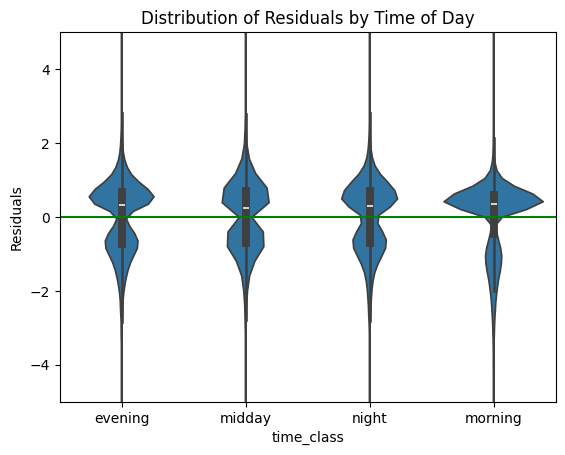

In [326]:
sns.violinplot(x='time_class', y=resids, data=model_data)
plt.ylabel('Residuals')
plt.ylim(-5,5)
plt.axhline(y=0, color='g', linestyle='-')
plt.title('Distribution of Residuals by Time of Day')
plt.show()

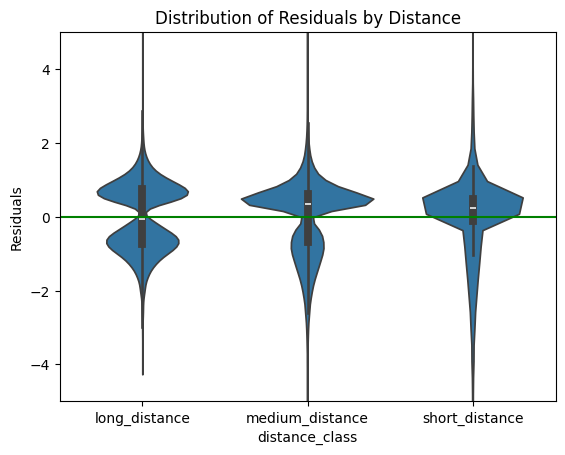

In [327]:
sns.violinplot(x='distance_class', y=resids, data=model_data)
plt.ylabel('Residuals')
plt.ylim(-5,5)
plt.axhline(y=0, color='g', linestyle='-')
plt.title('Distribution of Residuals by Distance')
plt.show()

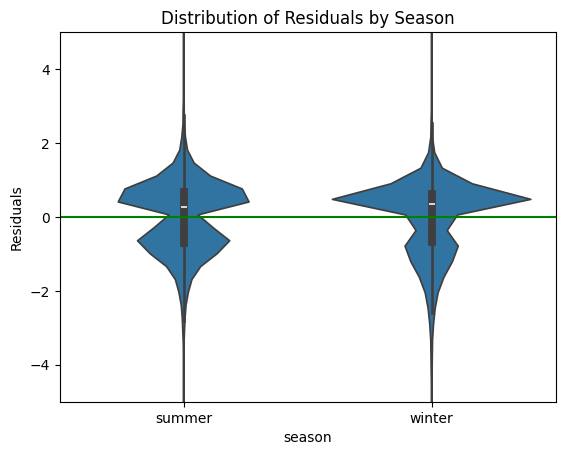

In [328]:
sns.violinplot(x='season', y=resids, data=model_data)
plt.ylabel('Residuals')
plt.ylim(-5,5)
plt.axhline(y=0, color='g', linestyle='-')
plt.title('Distribution of Residuals by Season')
plt.show()

### Testing the model
I'll link this guide: https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/

In [329]:
test_data['predict_efficiency_prob'] = model_fitted.predict(test_data)
test_data['predict_class'] = (test_data['predict_efficiency_prob'] > 0.5).astype(int)
test_data['predict_class'].value_counts()

predict_class
1    10725
0     5722
Name: count, dtype: int64

In [330]:
test_cm = confusion_matrix(test_data['cyclist_class'], test_data['predict_class']) 
print("TEST SET RESULTS:")
print("Confusion Matrix:")
print(test_cm) 
print(f'Test accuracy = {accuracy_score(test_data['cyclist_class'], test_data['predict_class'])}')

TEST SET RESULTS:
Confusion Matrix:
[[4136 2608]
 [1586 8117]]
Test accuracy = 0.7449990879795707


In [332]:
model_data.to_csv('../data/result/data.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)